In [1]:
!pip install yfinance
!pip install pandas_datareader


[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import abc
import datetime as dt
from dataclasses import dataclass
from typing import Callable
from enum import Enum
from tqdm import tqdm

from functools import lru_cache

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import pandas_datareader.data as reader
import yfinance as yfin

yfin.pdr_override()
RANDOM_SEED = 12

## 0. Investment Idea.

**Idea**: *Long correlation in dividend stocks, as investors will rebalance from bonds to dividend stock simultaneously due to expectation of lower interest rates.*\
**Product**: *BarrierReverseConvertible*\
**Target Client**: *Retail / Private / UHNWI that seeks bond-like payoff*

**Description**:\
It is no secret for anyone that the past period of QE have driven CBs around the world to the point, where they need to switch to QT very rapidly. Therefore, current high level of interest rates across the globe has allowed economies to slow down to presumably sufficient speed of growth (i.e., inflation has successfully slowed down).

However, as CBs are expected to start lowering the rates soon, which seems to be quite an obvious scenario for the market, such a movement is already priced in. Thus, how can we profit from such a prediction further, without interfering into the markets guessing game with the Fed?

The idea is to use the prediction for our advantage via trading second moments of the stock returns. As the **interest rates will go down**, investors that aim to have stable fixed income will likely start to look into **another sources of cash flows, such as dividend stocks**. Therefore, as many investors will sell bonds and **enter dividend stocks simultaneously, their correlation is expected to rise**.

Thus, investment idea is for client to buy a structure that will provide resemblence with the bonds by its payoff and be long correlation between dividend stocks. Therefore, we should offer clients such product.

## 1. Market Data for Stocks.

Let's download stocks data for S&P500 Index Constituents. The S&P500 stocks are chosen to be liquid enough for hedging greeks and to be familiar for the client that will buy the structure.

In [3]:
N_YEARS = 20
YEARS_TILL_MATURITY = 3
TODAY = dt.datetime(2024, 5, 3)

DIVIDEND_N_YEARS = 1
N_STOCKS = 3

In [4]:
SPX_TICKERS = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[
    0
]
SPX_TICKERS

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [5]:
tickers = SPX_TICKERS.copy()
tickers["yfin"] = tickers["Symbol"].apply(lambda x: yfin.Ticker(x))

For our investment idea we need to choose dividends aristocrats - stocks that pay **high** dividends in **stable** manner. Therefore, let's calculate the dividend ratio - it will allow to pick stocks that have large average dividend (**high**) with low standard deviation (**stable**).

In [6]:
def get_average_dividends(ticker: yfin.Ticker) -> float:
    yfin_data = ticker.dividends
    if isinstance(yfin_data.index, pd.RangeIndex):
        yfin_data.index = pd.DatetimeIndex(yfin_data.index).tz_localize("GMT")

    dividends = yfin_data[
        yfin_data.index.tz_convert(None)
        >= dt.datetime(TODAY.year - N_YEARS, TODAY.month, TODAY.day)
    ]
    dividends_std = dividends.std()

    if dividends_std == 0:
        return np.nan

    dividend_ratio = dividends.mean() / dividends_std

    if np.isinf(dividend_ratio) or np.isnan(dividend_ratio):
        return np.nan

    return dividend_ratio


tickers["avg_div"] = tickers["yfin"].apply(lambda x: get_average_dividends(x)).fillna(0)
tickers

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 1925-07-19 -> 2024-06-25)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,yfin,avg_div
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,yfinance.Ticker object <MMM>,2.120249
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,yfinance.Ticker object <AOS>,1.190689
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,yfinance.Ticker object <ABT>,1.630628
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),yfinance.Ticker object <ABBV>,2.253520
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,yfinance.Ticker object <ACN>,3.037012
...,...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011,yfinance.Ticker object <XYL>,2.577175
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,yfinance.Ticker object <YUM>,1.605143
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,yfinance.Ticker object <ZBRA>,0.000000
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,yfinance.Ticker object <ZBH>,11.416993


In [7]:
tickers["market_cap"] = (
    tickers["yfin"].apply(lambda x: get_average_dividends(x)).fillna(0)
)
tickers

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 1925-07-19 -> 2024-06-25)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,yfin,avg_div,market_cap
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,yfinance.Ticker object <MMM>,2.120249,2.120249
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,yfinance.Ticker object <AOS>,1.190689,1.190689
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,yfinance.Ticker object <ABT>,1.630628,1.630628
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),yfinance.Ticker object <ABBV>,2.253520,2.253520
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,yfinance.Ticker object <ACN>,3.037012,3.037012
...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011,yfinance.Ticker object <XYL>,2.577175,2.577175
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,yfinance.Ticker object <YUM>,1.605143,1.605143
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,yfinance.Ticker object <ZBRA>,0.000000,0.000000
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,yfinance.Ticker object <ZBH>,11.416993,11.416993


Further, let's download market data that will provide us needed statistical metrics for modelling the paths in Monte Carlo.

In [8]:
@dataclass
class Ticker:
    name: str
    code: str


class Tickers:
    def __init__(self, tickers: list[Ticker]):
        self._tickers = tickers

        self._ticker_dict = self._get_ticker_dict(tickers)
        self._ticker_inverse_dict = self._get_ticker_inverse_dict(tickers)

        self.names = list(self._ticker_dict.keys())
        self.codes = list(self._ticker_dict.values())

    @staticmethod
    def _get_ticker_dict(tickers: list[Ticker]) -> dict[str, str]:
        return {ticker.name: ticker.code for ticker in tickers}

    @staticmethod
    def _get_ticker_inverse_dict(tickers: list[Ticker]) -> dict[str, str]:
        return {ticker.code: ticker.name for ticker in tickers}

    def __len__(self):
        return len(self._tickers)

    def __getitem__(self, item: [int, str]) -> [str, None]:
        if isinstance(item, int):
            return self._tickers[item]
        elif isinstance(item, str):
            if item in self._ticker_dict.keys():
                return self.get(item)
            elif item in self._ticker_inverse_dict.keys():
                return self.get_inverse(item)
            else:
                return None
        else:
            raise TypeError(f"Item {item} is not a valid ticker or index")

    def get(self, name: str) -> str:
        return self._ticker_dict[name]

    def get_inverse(self, code: str) -> str:
        return self._ticker_inverse_dict[code]

    def __iter__(self):
        return iter(self._tickers)

In [9]:
class MarketData:
    TRADING_DAYS = 252
    TARGET_COLUMN = "Adj Close"

    def __init__(
        self,
        tickers: Tickers,
        start: [dt.datetime, int],
        end: dt.datetime,
        sampling_period: str = "D",
    ):
        self.df = None
        self.sampling_period = sampling_period

        self.tickers = tickers
        self.end = end

        if isinstance(start, dt.datetime):
            self.start = start
        else:
            self.start = dt.date(self.end.year - N_YEARS, self.end.month, self.end.day)

        self._initialize()

    def __len__(self):
        return len(self.tickers)

    def _load_yahoo(self) -> None:
        self.df = reader.get_data_yahoo(self.tickers.codes, self.start, self.end)[
            self.TARGET_COLUMN
        ]

    def _resample_data(self) -> None:
        if self.df is None:
            self._load_yahoo()
        self.df = self.df.resample(self.sampling_period).first().dropna(axis=0)
        self._df_returns = self.df.pct_change(fill_method=None).dropna(axis=0)

    def _initialize(self) -> None:
        self._load_yahoo()
        self._resample_data()

    def plot(self) -> None:
        n_stocks = len(self._df_returns.columns)

        ax = (
            self._df_returns.stack()
            .reset_index()
            .rename(columns={0: "return"})
            .hist(
                column="return",
                by="Ticker",
                range=[self.df.min().min(), self.df.max().max()],
                bins=100,
                grid=False,
                figsize=(16, 16),
                layout=(n_stocks, 1),
                sharex=True,
                color="#86bf91",
                zorder=2,
                rwidth=0.9,
            )
        )

        for i, x in enumerate(ax):
            x.tick_params(
                axis="both",
                which="both",
                bottom="off",
                top="off",
                labelbottom="on",
                left="off",
                right="off",
                labelleft="on",
            )

            vals = x.get_yticks()
            for tick in vals:
                x.axhline(
                    y=tick, linestyle="dashed", alpha=0.4, color="#eeeeee", zorder=1
                )

            x.set_xlabel(
                f"Daily Return ({self.start.year}-{self.end.year})",
                labelpad=20,
                weight="bold",
                size=16,
            )

            x.set_title(f"{self.tickers[self.df.columns[i]]}", size=12)

            if i == n_stocks // 2:
                x.set_ylabel("Frequency", labelpad=50, weight="bold", size=12)

            x.tick_params(axis="x", rotation=0)

    def __getitem__(self, item: [int, str], *args, **kwargs):
        if isinstance(item, int):
            return self.df.iloc[:, item].values
        elif isinstance(item, str):
            if item in self.df.columns:
                return self.df.loc[:, item].values
            else:
                return self.df.loc[:, self.tickers[item]].values
        else:
            raise TypeError(f"Item {item} is not a valid ticker or index")

    def get_means(self) -> np.array:
        return self._df_returns.mean().to_numpy() * self.TRADING_DAYS

    def get_var_covar(self) -> np.array:
        return self._df_returns.cov().to_numpy() * self.TRADING_DAYS

    def get_corr(self) -> np.array:
        return self._df_returns.corr().to_numpy()

    @lru_cache(maxsize=None)
    def get_dividends(self) -> np.array:
        # return np.array([yfin.Ticker(ticker).dividends.iloc[-1] / 100 for ticker in self.tickers.codes])
        return np.array([0 for ticker in self.tickers.codes])

## 2. Investment Idea.

Let's get data to support our investment thesis and check that there is indeed negative correlation between rates and our top-3 dividend stocks.

In [10]:
tickers_no_outliers = tickers[(np.abs(stats.zscore(tickers["avg_div"])) < 3)]
top_dividend_stocks = tickers_no_outliers.sort_values("avg_div", ascending=False).iloc[
    :N_STOCKS, :
]

In [11]:
tickers_no_outliers

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,yfin,avg_div,market_cap
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,yfinance.Ticker object <MMM>,2.120249,2.120249
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,yfinance.Ticker object <AOS>,1.190689,1.190689
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,yfinance.Ticker object <ABT>,1.630628,1.630628
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),yfinance.Ticker object <ABBV>,2.253520,2.253520
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,yfinance.Ticker object <ACN>,3.037012,3.037012
...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011,yfinance.Ticker object <XYL>,2.577175,2.577175
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,yfinance.Ticker object <YUM>,1.605143,1.605143
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,yfinance.Ticker object <ZBRA>,0.000000,0.000000
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,yfinance.Ticker object <ZBH>,11.416993,11.416993


In [12]:
market_data_tickers = Tickers(
    top_dividend_stocks.apply(
        lambda row: Ticker(name=row.Security, code=row.Symbol), axis=1
    ).to_list()
)
market_data_tickers

In [13]:
md = MarketData(market_data_tickers, N_YEARS, TODAY)

[*********************100%%**********************]  3 of 3 completed


How can we measure by some scalar metric that the correlation matrix indeed show higher correlation? We can simply calculate the mean correlation of upper triangle (or of all values, expect diagonal, as the matrix is symmetric) and check, if the correlation is indeed higher on average.

In [14]:
hist_corr = []
for date, data in md.df.rolling(180).corr().dropna().groupby(level=0):
    data = data.to_numpy()
    np.fill_diagonal(data, 0)
    hist_corr.append([date, data.mean()])
hist_corr = pd.DataFrame(hist_corr, columns=["Date", "Corr"]).set_index("Date")

In [15]:
hist_corr

,Corr
Date,
2019-11-25,0.099432
2019-11-26,0.110636
2019-11-27,0.121771
2019-11-29,0.132686
2019-12-02,0.142240
...,...
2024-04-26,0.071172
2024-04-29,0.077172
2024-04-30,0.080851


For interest rate ticker let's use ^FVX - 5-year UST rates. We need the rates of the term that is expected to match the period, at which the fixed income investors (which we expect to substitute respective bonds with the dividend stocks) usually look, when placing investment decisions. Therefore, 5 years seem to be an appropriate term.

In [16]:
IR_TICKER = "^FVX"
md_ir = MarketData(
    Tickers([Ticker(name="USD IR rate", code=IR_TICKER)]), N_YEARS, TODAY
)
hist_corr.join(md_ir.df, how="left").corr()

[*********************100%%**********************]  1 of 1 completed


,Corr,Adj Close
Corr,1.000000,-0.534208
Adj Close,-0.534208,1.000000


We can see that the rates (absolute level) and correlations (absolute level, not change) exhibit **high negative correlation**, thus, **our investment thesis seems to be correct** - lower levels of interest rates can be expected to correlate with the higher correlation between our 3 dividend stocks, chosen for the target structure.

However, as 5-year USTs correspond to market expectations of the future interest rates, investors may already be looking into substituting those by the dividend stocks in their portfolios, thus, this investment idea is driven not fully by the realized expectations of the market that we know now, but also dependent on the future movements of 5-year USTs - thus, we need to be careful with correct period of the maturity for our Barrier Reverse Convertible note.

Also, let's check the chart for the changes in the rate in absolute scale (first chart) and the scale that starts at 1 (second chart).

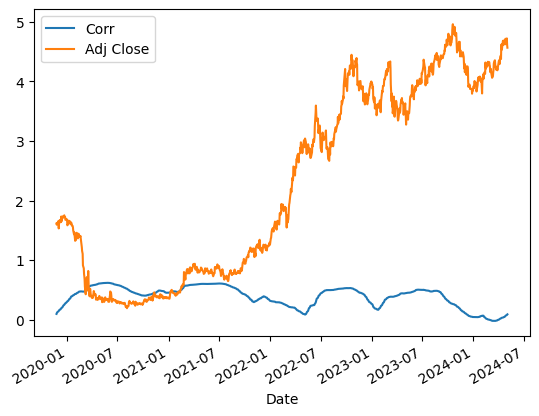

In [17]:
hist_corr.join(md_ir.df, how="left").plot();

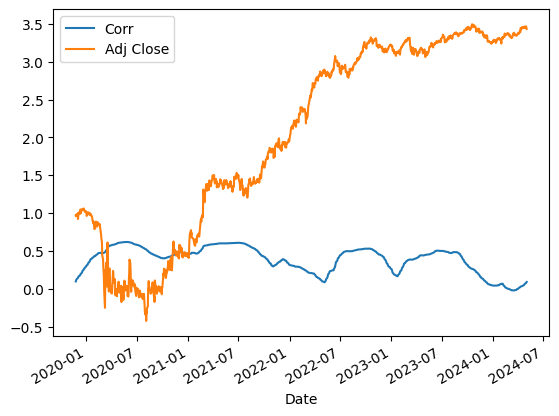

In [18]:
hist_corr.join(md_ir.df.pct_change().dropna().cumsum(), how="left").plot();

Moreover, we can notice that the **correlation is currently pretty close to the minimum** values across 4-year values, thus, the idea to **take correlation long** might prove to be reasonable from this standpoint too.

Therefore, our investment idea looks reasonable from the data analysis standpoint. Thus, let's fix the chosen stocks and move on with the pricing.

In [19]:
for stock in md.tickers:
    print(stock)

Ticker(name='Hilton Worldwide', code='HLT')
Ticker(name='United Rentals', code='URI')
Ticker(name='Fox Corporation (Class B)', code='FOX')


## 3. Interest Rate Curve.

We also need to use correct interest rate for our calculations, as the interest rate should not be fixed throughout our Monte Carlo paths. Therefore, let's use Nelson-Siegel-Svensson interpolation of rates, taken from https://www.federalreserve.gov/data/nominal-yield-curve.htm.

In [20]:
class YieldCurve:
    TARGET_COLUMN = "ytm"
    DISCOUNT_FACTOR_COLUMN = "discount_factor"
    FWD_RATE_COLUMN = "fwd_rate"

    def __init__(self, initial_terms: np.array, *args, **kwargs) -> None:
        self._rates_df = None
        self._discount_factors = None
        self._instant_fwd_rate = None

        self._initialize(initial_terms)

    def _initialize(self, terms: np.array) -> None:
        self.create_curve(terms=terms)

    @abc.abstractmethod
    def get_rates(self, terms: list[float]) -> np.array:
        pass

    def create_curve(self, terms: list[float]) -> None:
        self._rates_df = pd.DataFrame(
            self.get_rates(terms), index=terms, columns=[self.TARGET_COLUMN]
        )
        self._create_discount_factors()
        self._create_instant_fwd_rates()

    def _create_discount_factors(self) -> pd.DataFrame:
        if self._rates_df is None:
            raise ValueError("Rate data is not fitted yet!")
        discount_factors = np.exp(
            -self._rates_df[self.TARGET_COLUMN] * self._rates_df.index
        )
        self._discount_factors = pd.DataFrame(
            discount_factors,
            index=self._rates_df.index,
            columns=[self.DISCOUNT_FACTOR_COLUMN],
        )
        return self._discount_factors

    def _create_instant_fwd_rates(self) -> pd.DataFrame:
        if self._discount_factors is None:
            raise ValueError("Discount factor data is not fitted yet!")

        t_old = self._rates_df.index[0]
        instant_fwd_rates = []
        for t in self._rates_df.index[1:]:
            dt = t - t_old
            instant_fwd_rates.append(
                -1
                / dt
                * (
                    np.log(
                        self._discount_factors.loc[t, self.DISCOUNT_FACTOR_COLUMN]
                        / self._discount_factors.loc[t_old, self.DISCOUNT_FACTOR_COLUMN]
                    )
                )
            )
            t_old = t
        self._instant_fwd_rate = pd.DataFrame(
            instant_fwd_rates,
            index=self._rates_df.index[1:],
            columns=[self.FWD_RATE_COLUMN],
        )
        return self._instant_fwd_rate

    @property
    def curve_df(self) -> pd.DataFrame:
        if self._rates_df is None:
            raise ValueError("Rate data is not fitted yet! Call .create_curve() first.")
        return self._rates_df

    @property
    def discount_factors_df(self) -> pd.DataFrame:
        return self._discount_factors

    @property
    def instant_fwd_rates_df(self) -> pd.DataFrame:
        return self._instant_fwd_rate

    @staticmethod
    def _find_point(curve: pd.DataFrame, term: float) -> float:
        index = np.absolute(curve.index - term).argmin()
        return curve.iloc[index].values[0]

    @lru_cache(maxsize=None)
    def get_rate(self, term: float) -> float:
        return self._find_point(self._rates_df, term)

    @lru_cache(maxsize=None)
    def get_discount_factor(self, term: float) -> float:
        return self._find_point(self._discount_factors, term)

    @lru_cache(maxsize=None)
    def get_instant_fwd_rate(self, term: float) -> float:
        return self._find_point(self._instant_fwd_rate, term)

In [21]:
class NelsonSiegelCurve(YieldCurve):
    def __init__(
        self,
        b0: float,
        b1: float,
        b2: float,
        tau: float,
        initial_terms: np.array = np.linspace(1 / 365, 25.0, 100),
    ) -> None:
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.tau = tau

        super().__init__(initial_terms)

    def get_rates(self, terms: list[float]) -> np.array:
        terms = np.array(terms)
        rates = (
            self.b0
            + (self.b1 + self.b2) * self.tau / terms * (1 - np.exp(-terms / self.tau))
            - self.b2 * np.exp(-terms / self.tau)
        )
        return rates / 100

In [22]:
ns_params = pd.read_csv("data/feds200628.csv", index_col=0).dropna(axis=0)
ns_params

,BETA0,BETA1,BETA2,BETA3,SVEN1F01,SVEN1F04,SVEN1F09,SVENF01,SVENF02,SVENF03,...,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30,TAU1,TAU2
Date,,,,,,,,,,,,,,,,,,,,,
1985-11-25,11.581031,-4.400923,-618.930844,619.464293,9.0651,10.4419,10.9606,8.4379,9.2418,9.7502,...,10.5553,10.5893,10.6217,10.6526,10.6819,10.7099,10.7365,10.7618,4.373887,4.360767
1985-11-26,11.379558,-4.194589,-618.775570,619.619254,9.0571,10.4505,10.9626,8.4308,9.2347,9.7486,...,10.5139,10.5435,10.5715,10.5982,10.6234,10.6474,10.6701,10.6917,4.290276,4.279636
1985-11-27,11.430107,-4.273176,-618.903298,619.491772,9.0564,10.3942,10.8819,8.4309,9.2299,9.7254,...,10.4853,10.5176,10.5482,10.5773,10.6049,10.6311,10.6560,10.6796,4.184567,4.172570
1985-11-29,11.401138,-4.329607,-618.992635,619.402604,9.0318,10.3279,10.8162,8.4018,9.2064,9.6876,...,10.4526,10.4861,10.5179,10.5479,10.5763,10.6032,10.6287,10.6528,3.922352,3.910549
1985-12-02,11.376185,-4.282876,-618.980817,619.414369,9.0689,10.4183,10.9797,8.4323,9.2478,9.7445,...,10.5534,10.5842,10.6131,10.6402,10.6657,10.6897,10.7123,10.7335,3.648561,3.639932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06,1.492339,3.945759,0.000404,9.534620,4.5629,4.2273,4.7509,4.7207,4.3454,4.1869,...,4.7192,4.7202,4.7185,4.7143,4.7078,4.6992,4.6885,4.6760,2.578433,16.273388
2024-05-07,1.356047,4.087681,0.000096,9.800446,4.5599,4.1945,4.7033,4.7224,4.3374,4.1682,...,4.6854,4.6864,4.6848,4.6806,4.6741,4.6654,4.6547,4.6421,2.654762,16.417864
2024-05-08,1.670731,3.768133,-0.000610,9.008743,4.5775,4.2405,4.7403,4.7322,4.3618,4.2039,...,4.7155,4.7169,4.7159,4.7125,4.7070,4.6994,4.6898,4.6785,2.546731,16.388992


In [23]:
ns_curve = NelsonSiegelCurve(
    b0=ns_params["BETA0"].iloc[-1],
    b1=ns_params["BETA1"].iloc[-1],
    b2=ns_params["BETA2"].iloc[-1],
    tau=ns_params["TAU1"].iloc[-1],
)

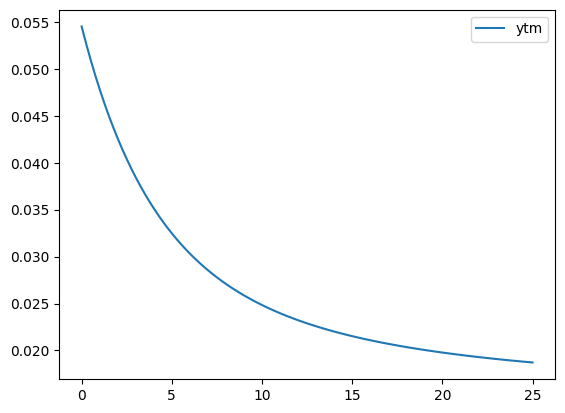

In [24]:
ns_curve.curve_df.plot();

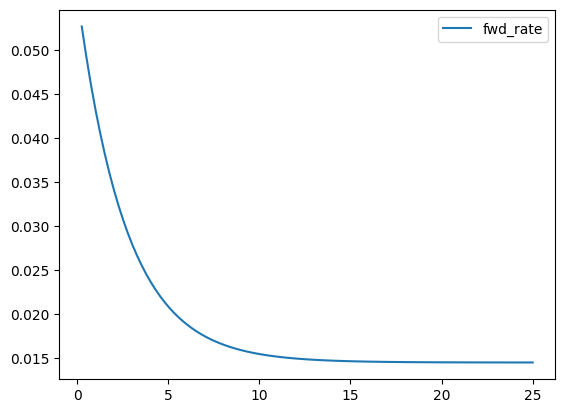

In [25]:
ns_curve.instant_fwd_rates_df.plot();

## 4. Monte Carlo Modelling.

Next step is to create a Monte Carlo pricer that will be used to determine the future value of a derivative.

The pricer is implemented to have **maximum flexibility** in terms of coding framework. We **need to specify only a payoff function** to our pricer, and it will return the respective price of a derivative. Therefore, we do not have to implement Monte Carlo for each derivative, but can use this pricer for any payoff that we can possibly create.

In [26]:
class MonteCarloPricer:
    PATHS = 20_000
    # PATHS = 1_000
    TRADING_DAYS: int = 252

    def __init__(
        self,
        payoff_function: Callable[[np.array], float],
        random_seed: [int, None] = RANDOM_SEED,
    ):
        self.payoff_function = payoff_function
        self.random_seed = random_seed

    def _geometric_brownian_motion(
        self,
        current_spot: list[float],
        days_till_maturity: int,
        risk_free_rate_fn: Callable[[float], float],
        dividends_fn: Callable[[float], float],
        var_covar_fn: Callable[[float], np.array],
        n_paths: [int, None] = None,
        *args,
        **kwargs,
    ) -> np.array:
        if n_paths is None:
            n_paths = self.PATHS

        t = days_till_maturity
        n_stocks = len(current_spot)

        time = np.linspace(0, t / self.TRADING_DAYS, t)
        d_time = time[1] - time[0]

        drift = []
        cholesky = []
        for t in time:
            var_covar = var_covar_fn(t)
            drift.append(
                [
                    (
                        risk_free_rate_fn(t)
                        - dividends_fn(t)
                        - 0.5 * np.diag(var_covar) ** 2
                    )
                    * d_time
                ]
            )
            cholesky.append(np.linalg.cholesky(var_covar))

        drift = np.array(drift).reshape(1, len(time), n_stocks, 1)
        cholesky = np.array(cholesky).reshape(1, len(time), n_stocks, n_stocks)

        np.random.seed(self.random_seed)
        diffusion = (
            cholesky
            @ np.random.normal(0, 1, size=(n_paths, len(time), n_stocks, 1))
            * np.sqrt(d_time)
        )
        paths = np.exp(drift + diffusion)
        paths = np.insert(paths, 0, np.array(current_spot).reshape(1, 1, -1, 1), axis=1)
        paths = np.cumprod(paths, axis=1).squeeze(3)

        return paths

    def get_paths(
        self,
        current_spot: list[float],
        time_till_maturity: float,
        risk_free_rate_fn: Callable[[float], float],
        dividends_fn: Callable[[float], float],
        var_covar_fn: Callable[[float], np.array],
        n_paths: [int, None] = None,
    ) -> np.array:
        return self._geometric_brownian_motion(
            current_spot=current_spot,
            days_till_maturity=int(round(self.TRADING_DAYS * time_till_maturity)),
            risk_free_rate_fn=risk_free_rate_fn,
            dividends_fn=dividends_fn,
            var_covar_fn=var_covar_fn,
            n_paths=n_paths,
        )

    def get_future_value(
        self,
        current_spot: list[float],
        time_till_maturity: float,
        risk_free_rate_fn: Callable[[float], float],
        dividends_fn: Callable[[float], float],
        var_covar_fn: Callable[[float], np.array],
        n_paths: [int, None] = None,
    ) -> float:
        random_paths = self._geometric_brownian_motion(
            current_spot=current_spot,
            days_till_maturity=int(round(self.TRADING_DAYS * time_till_maturity)),
            risk_free_rate_fn=risk_free_rate_fn,
            dividends_fn=dividends_fn,
            var_covar_fn=var_covar_fn,
            n_paths=n_paths,
        )

        instrument_payoffs = self.payoff_function(random_paths)

        return np.mean(instrument_payoffs)

## 5. Pricing Framework.

Now, let's move on to the pricing framework. In this notebook the pricing OOP is implemented to be as flexible as possible in terms of the pricing.

Basically, it requires only determining the payoff functions for each base instrument / base derivative. And then you can obtain structured product by effectively combining the respective objects. For instance, to create a Capital Protection Note, which consists of long deposit / risk-free instrument and long call / put option, we simply need to write:
$$capital\_protection\_note = RiskFreeBond(**params) + Option(**params)$$.

In [27]:
class PositionSide(Enum):
    LONG = 1
    SHORT = -1

In [28]:
class Instrument:
    CALENDAR_DAYS: int = 365

    def __init__(self):
        pass

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    @abc.abstractmethod
    def coupon(self, frequency: float = 0.0, *args, **kwargs) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def pv_coupons(self) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def price(self, spot_start: [float, list[float], None] = None) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def payoff(self, spot_paths: np.array) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.LONG, other)])

    def __sub__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.SHORT, other)])

In [29]:
class StructuredNote:
    def __init__(
        self, instruments: [list[tuple[PositionSide, Instrument]], None] = None
    ):
        if instruments is not None:
            self.instruments = instruments
        else:
            self.instruments = []

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    def coupon(
        self, frequency: float = 0.0, commission: float = 0.0, *args, **kwargs
    ) -> float:
        return sum(
            [
                instrument.coupon(frequency, commission)
                for _, instrument in self.instruments
            ]
        )

    def __add__(self, other: Instrument):
        return self.instruments.append((PositionSide.LONG, other))

    def __sub__(self, other: Instrument):
        return self.instruments.append((PositionSide.SHORT, other))

    def price(self) -> float:
        return sum(
            [
                side.value * instrument.price() + instrument.pv_coupons()
                for side, instrument in self.instruments
            ]
        )

    def payoff(self, spot_paths: np.array) -> float:
        return sum(
            [
                side.value * instrument.payoff(spot_paths)
                for side, instrument in self.instruments
            ]
        )

    def __repr__(self):
        sp_str = f"StructuredNote of:\n"
        for side, instrument in self.instruments:
            sp_str += f"* {side} -> {instrument}\n"
        return sp_str

    def __str__(self):
        return self.__repr__()

In [30]:
def annuity_factor(annual_rate: float, frequency: float, till_maturity: float) -> float:
    rate = annual_rate * frequency
    number_of_payments = till_maturity / frequency
    return (1 - (1 + rate) ** (-number_of_payments)) / rate

In [31]:
class RiskFreeBond(Instrument):
    CALENDAR_DAYS: int = 365

    def __init__(
        self,
        yield_curve: YieldCurve,
        start_date: dt.datetime,
        end_date: dt.datetime,
    ):
        super().__init__()
        self.yield_curve = yield_curve
        self.start_date = start_date
        self.end_date = end_date

        self.time_till_maturity = (
            self.end_date - self.start_date
        ).days / self.CALENDAR_DAYS

    def pv_coupons(self) -> float:
        return 1 - self.price()

    def coupon(self, frequency: float = 0.0, *args, **kwargs) -> float:
        if frequency > 0:
            annual_rate = self.yield_curve.get_rate(self.time_till_maturity)
            return self.pv_coupons() / annuity_factor(
                annual_rate=annual_rate,
                frequency=frequency,
                till_maturity=self.time_till_maturity,
            )
        return 0

    def price(self, spot_start: [float, list[float], None] = None):
        return self.yield_curve.get_discount_factor(self.time_till_maturity)

    def payoff(self, spot_paths: np.array) -> float:
        return 1

    def __repr__(self):
        instrument_str = f"RiskFreeBond:\n"
        instrument_str += f"* Term = {round(self.time_till_maturity, 2)} years\n"
        instrument_str += f"* YTM = {round(self.yield_curve.get_rate(self.time_till_maturity) * 100, 2)}%\n"
        instrument_str += f"* Start Date = {self.start_date}\n"
        instrument_str += f"* End Date = {self.end_date}\n"
        return instrument_str

In [32]:
class ExoticOption(Instrument):
    # 50 bps
    DEFAULT_SPOT_CHANGE: float = 0.5 / 100

    def __init__(
        self,
        underlyings: MarketData,
        yield_curve: YieldCurve,
        strike_level: [float, list[float]],
        start_date: dt.datetime,
        end_date: dt.datetime,
        *args,
        **kwargs
    ):
        super().__init__()

        self.underlyings = underlyings
        self.yield_curve = yield_curve
        self.strike_level = strike_level
        self.start_date = start_date
        self.end_date = end_date

        self.time_till_maturity = (
            self.end_date - self.start_date
        ).days / self.CALENDAR_DAYS
        self._price = None

        self._mc_pricer = MonteCarloPricer(self.payoff)

    @lru_cache(maxsize=None)
    def _volatility_surface(self, term: float) -> np.array:
        return self.underlyings.get_var_covar()

    @lru_cache(maxsize=None)
    def _dividends(self, term: float) -> np.array:
        return self.underlyings.get_dividends()

    def delta(
        self, spot_change: [float, None] = None, spot_start: [list[float], None] = None
    ) -> np.array:
        if spot_change is None:
            spot_change = self.DEFAULT_SPOT_CHANGE

        n_stocks = len(self.underlyings)
        spot_up = np.exp(spot_change)
        spot_down = np.exp(-spot_change)

        delta = []
        for i in range(n_stocks):
            if spot_start is None:
                x_up, x_down = [1] * n_stocks, [1] * n_stocks
            else:
                x_up, x_down = spot_start.copy(), spot_start.copy()

            x_up[i] *= spot_up
            x_down[i] *= spot_down

            price_up = self.price(x_up)
            price_down = self.price(x_down)

            delta.append((price_up - price_down) / (spot_up - spot_down))

        return np.array(delta)

    def gamma(
        self, spot_change: [float, None] = None, spot_start: [list[float], None] = None
    ) -> np.array:
        if spot_change is None:
            spot_change = self.DEFAULT_SPOT_CHANGE

        n_stocks = len(self.underlyings)
        spot_up = np.exp(spot_change)
        spot_down = np.exp(-spot_change)

        gamma = []
        for i in range(n_stocks):
            if spot_start is None:
                x_up, x_down = [1] * n_stocks, [1] * n_stocks
            else:
                x_up, x_down = spot_start.copy(), spot_start.copy()

            x_up[i] *= spot_up
            x_down[i] *= spot_down

            delta_up = self.delta(spot_start=x_up)
            delta_down = self.delta(spot_start=x_down)

            gamma.append((delta_up - delta_down) / (spot_up - spot_down))

        return np.array(gamma)

    def vega(
        self, vol_change: float = 0.01, spot_start: [list[float], None] = None
    ) -> np.array:
        n_stocks = len(self.underlyings)
        diagonal = np.diag(np.sqrt(np.diag(self.underlyings.get_var_covar())))
        corr = self.underlyings.get_corr()
        price_down = self.price()

        vega = []
        for i in range(n_stocks):
            diag = diagonal.copy()
            diag[i][i] += vol_change
            new_var_covar = diag @ corr @ diag

            future_value_new = self._mc_pricer.get_future_value(
                current_spot=spot_start
                if spot_start is not None
                else [1.0] * len(self.underlyings),
                time_till_maturity=self.time_till_maturity,
                risk_free_rate_fn=self.yield_curve.get_instant_fwd_rate,
                dividends_fn=self._dividends,
                var_covar_fn=lambda term: new_var_covar,
            )
            price_up = future_value_new * self.yield_curve.get_discount_factor(
                self.time_till_maturity
            )

            vega.append((price_up - price_down) / vol_change)

        return np.array(vega)

    def correlation_sensitivity(
        self, corr_change: float = 0.01, spot_start: [list[float], None] = None
    ) -> np.array:
        n_stocks = len(self.underlyings)
        diagonal = np.diag(np.sqrt(np.diag(self.underlyings.get_var_covar())))
        correlation = self.underlyings.get_corr()
        price_down = self.price()

        vega = []
        for i in range(n_stocks - 1):
            corr = correlation.copy()
            corr[i][i + 1] += corr_change
            corr[i + 1][i] += corr_change
            new_var_covar = diagonal @ corr @ diagonal

            future_value_new = self._mc_pricer.get_future_value(
                current_spot=spot_start
                if spot_start is not None
                else [1.0] * len(self.underlyings),
                time_till_maturity=self.time_till_maturity,
                risk_free_rate_fn=self.yield_curve.get_instant_fwd_rate,
                dividends_fn=self._dividends,
                var_covar_fn=lambda term: new_var_covar,
            )
            price_up = future_value_new * self.yield_curve.get_discount_factor(
                self.time_till_maturity
            )

            vega.append((price_up - price_down) / corr_change)

        return np.array(vega)

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        future_value = self._mc_pricer.get_future_value(
            current_spot=spot_start
            if spot_start is not None
            else [1.0] * len(self.underlyings),
            time_till_maturity=self.time_till_maturity,
            risk_free_rate_fn=self.yield_curve.get_instant_fwd_rate,
            dividends_fn=self._dividends,
            var_covar_fn=self._volatility_surface,
        )
        return future_value * self.yield_curve.get_discount_factor(
            self.time_till_maturity
        )

    def get_paths(self, spot_start: [float, list[float], None] = None) -> np.array:
        return self._mc_pricer.get_paths(
            current_spot=spot_start
            if spot_start is not None
            else [1.0] * len(self.underlyings),
            time_till_maturity=self.time_till_maturity,
            risk_free_rate_fn=self.yield_curve.get_instant_fwd_rate,
            dividends_fn=self._dividends,
            var_covar_fn=self._volatility_surface,
        )

    @abc.abstractmethod
    def __repr__(self):
        raise NotImplementedError

    @abc.abstractmethod
    def payoff(self, spot_paths: np.array) -> float:
        raise NotImplementedError

In [33]:
class WorstOfBarrierPut(ExoticOption):
    def __init__(
        self,
        underlyings: MarketData,
        yield_curve: YieldCurve,
        strike_level: float,
        barrier_level: float,
        start_date: dt.datetime,
        end_date: dt.datetime,
    ):
        super().__init__(
            underlyings=underlyings,
            yield_curve=yield_curve,
            strike_level=strike_level,
            start_date=start_date,
            end_date=end_date,
        )

        self.barrier_level = barrier_level

    def pv_coupons(self) -> float:
        return self.price()

    def coupon(
        self, frequency: float = 0.0, commission: float = 0.0, *args, **kwargs
    ) -> float:
        if frequency > 0:
            annual_rate = self.yield_curve.get_rate(self.time_till_maturity)
            return (self.pv_coupons() - commission) / annuity_factor(
                annual_rate=annual_rate,
                frequency=frequency,
                till_maturity=self.time_till_maturity,
            )
        return 0.0

    def __repr__(self):
        instrument_str = f"WorstOfBarrierPut:\n"
        underlyings = "\n".join(
            [f"-> {stock}" for stock in worst_of_barrier_put.underlyings.tickers]
        )
        instrument_str += underlyings
        instrument_str += f"* Strike = {self.strike_level * 100}\n"
        instrument_str += f"* Barrier = {self.barrier_level * 100}\n"
        instrument_str += f"* Start Date = {self.start_date}\n"
        instrument_str += f"* End Date = {self.end_date}\n"
        return instrument_str

    def payoff(self, spot_paths: np.array) -> np.array:
        indices = np.where(np.all(spot_paths[:, -1] >= self.barrier_level, axis=1))
        returns = self.strike_level - spot_paths[:, -1].min(axis=1)
        returns[indices] = 0

        return returns

## 6. Final Pricing.

Finally, let's use the framework for pricing a specified Barrier Reverse Convertible. The strike will be set at 100% (as it usually done for the BRC) and the barrier level is chosen to be 50% for the purpose of investment idea illustration. However, we can shift barrier at any level that the client desires - the lower the barrier, the lower the coupon (due to lower probability of the option being activated, thus, option being ITM).

The instrument provides the following payoff:
* Client receives the fixed coupon at specified frequency (for the purpose of illustration of the investment idea quarterly frequency is chosen, but it can be set at any level - the lower the frequency, the lower the coupon due to time value of money).
* At maturity, we check the prices of the 3 chosen stocks
* If all the stocks are above the barrier, client receives 100% of the invested notional (coupons are paid additionally)
* If at least one stock is below the barrier, client receives the respective % of invested notional without the amount by which the worst stock of all fell.

A potential way to choose the barrier is to ask the client the applicable $p$ probability of loss and calculate the barrier via Monte Carlo paths, such that in $p$% paths out of all the barrier is hit at maturity.

In [34]:
COUPON_FREQUENCY = 0.25
STRIKE_LEVEL = 1.0
BARRIER_LEVEL = 0.5

start_date = TODAY
end_date = dt.datetime(TODAY.year + YEARS_TILL_MATURITY, TODAY.month, TODAY.day)

worst_of_barrier_put = WorstOfBarrierPut(
    underlyings=md,
    yield_curve=ns_curve,
    strike_level=STRIKE_LEVEL,
    barrier_level=BARRIER_LEVEL,
    start_date=start_date,
    end_date=end_date,
)
risk_free_bond = RiskFreeBond(
    yield_curve=ns_curve, start_date=start_date, end_date=end_date
)
barrier_reverse_convertible = risk_free_bond - worst_of_barrier_put

In [35]:
print(
    f"Price of the instrument is {barrier_reverse_convertible.price() * 100:.2f}% at inception."
)

Price of the instrument is 100.00% at inception.


At inception instrument costs 100%, as nothing in the market have changed, and we still have a deposit, cash from option premium received and short option that costs exactly the premium we have received.

Let's check the premium of the sold option, which will be distributed as coupons to the client that holds the note.

In [36]:
print(
    f"Option premium of the Worst-Of Barrier Put is {worst_of_barrier_put.price() * 100:.2f}% at inception."
)

Option premium of the Worst-Of Barrier Put is 13.79% at inception.


Therefore, our final instrument is:

In [37]:
barrier_reverse_convertible

StructuredNote of:
* PositionSide.LONG -> RiskFreeBond:
* Term = 3.0 years
* YTM = 3.83%
* Start Date = 2024-05-03 00:00:00
* End Date = 2027-05-03 00:00:00

* PositionSide.SHORT -> WorstOfBarrierPut:
-> Ticker(name='Hilton Worldwide', code='HLT')
-> Ticker(name='United Rentals', code='URI')
-> Ticker(name='Fox Corporation (Class B)', code='FOX')* Strike = 100.0
* Barrier = 50.0
* Start Date = 2024-05-03 00:00:00
* End Date = 2027-05-03 00:00:00


Which consists of:

In [38]:
risk_free_bond

RiskFreeBond:
* Term = 3.0 years
* YTM = 3.83%
* Start Date = 2024-05-03 00:00:00
* End Date = 2027-05-03 00:00:00

In [39]:
worst_of_barrier_put

WorstOfBarrierPut:
-> Ticker(name='Hilton Worldwide', code='HLT')
-> Ticker(name='United Rentals', code='URI')
-> Ticker(name='Fox Corporation (Class B)', code='FOX')* Strike = 100.0
* Barrier = 50.0
* Start Date = 2024-05-03 00:00:00
* End Date = 2027-05-03 00:00:00

So, if the price is 100%, what should we quote to the investor? As the investor looks the fixed income-like payoff, we are quoting the level of the coupon that the client will receive.

In [40]:
brc_coupon = barrier_reverse_convertible.coupon(COUPON_FREQUENCY)
print(f"BRC Coupon = {round(brc_coupon * 100, 2)}% quarterly")
print(f"BRC Coupon = {round(brc_coupon * 100, 2) / COUPON_FREQUENCY}% p.a.")

BRC Coupon = 2.19% quarterly
BRC Coupon = 8.76% p.a.


However, we as investment bank should take some % as the commission from the PV of the structured note. Let's specify the commission and quote the final coupon to the client.

In [41]:
# For example, we can set commission to be 0.5% p.a., taken at inception
COMMISSION = 0.5 / 100 * YEARS_TILL_MATURITY
brc_coupon = barrier_reverse_convertible.coupon(COUPON_FREQUENCY, commission=COMMISSION)
print(f"BRC Coupon = {round(brc_coupon * 100, 2)}% quarterly")
print(f"BRC Coupon = {round(brc_coupon * 100, 2) / COUPON_FREQUENCY}% p.a.")

BRC Coupon = 2.06% quarterly
BRC Coupon = 8.24% p.a.


In [42]:
print(
    f"Risk-free alternative YTM = {ns_curve.get_rate(YEARS_TILL_MATURITY) * 100:.2f}%"
)

Risk-free alternative YTM = 3.83%


Therefore, our product offers slightly less than 5% of the premium to the risk-free rate for the risk undertaken, however, not taking into account the potentially rising correlation

## 7. Checking the Logic via Charts.

Let's plot Monte Carlo paths, check that they look logically coherent and compare the scenarios, where the barrier is hit vs where it is not.

In [43]:
def plot_paths(random_paths: np.array, market_data: MarketData) -> None:
    n_stocks = random_paths.shape[-1]

    plt.figure(figsize=(16, 10))
    plt.subplot(n_stocks + 1, 1, 1)

    plt.title(f"Stock Paths of {', '.join(market_data.tickers.codes)}")
    for i in range(n_stocks):
        plt.plot(random_paths[0, :, i].T, "g")
        plt.grid()
        plt.ylabel("Performance of stocks")

    for i in range(n_stocks):
        plt.subplot(n_stocks + 1, 1, i + 2)
        plt.plot(random_paths[:10, :, i].T, "--b")
        plt.grid()
        if i == n_stocks - 1:
            plt.xlabel("Time")
        plt.ylabel(market_data.tickers[i].name)

    plt.show()

In [44]:
def plot_barrier_hit(
    random_paths: np.array, market_data: MarketData, barrier_level: float
) -> None:
    n_stocks = random_paths.shape[-1]

    plt.figure(figsize=(16, 10))
    plt.subplot(n_stocks + 1, 1, 1)

    plt.title(f"Stock Paths of {', '.join(market_data.tickers.codes)}")
    barrier_hit_paths = random_paths[
        np.where(np.any(random_paths[:, -1] < barrier_level, axis=1))
    ]
    for i in range(n_stocks):
        if barrier_hit_paths[0, -1, i] >= barrier_level:
            plt.plot(barrier_hit_paths[0, :, i].T, "--g")
        else:
            plt.plot(barrier_hit_paths[0, :, i].T, "--r")
        plt.grid()
        plt.xlabel("Time")
        plt.ylabel("Performance of stocks")

    plt.plot(np.array([barrier_level] * paths.shape[1]), "m")

    plt.show()

In [45]:
def plot_barrier_not_hit(
    random_paths: np.array, market_data: MarketData, barrier_level: float
) -> None:
    n_stocks = random_paths.shape[-1]

    plt.figure(figsize=(16, 10))
    plt.subplot(n_stocks + 1, 1, 1)

    plt.title(f"Stock Paths of {', '.join(market_data.tickers.codes)}")
    barrier_not_hit_paths = random_paths[
        np.where(np.all(random_paths[:, -1] >= barrier_level, axis=1))
    ]
    for i in range(n_stocks):
        plt.plot(barrier_not_hit_paths[0, :, i].T, "--g")
        plt.grid()
        plt.xlabel("Time")
        plt.ylabel("Performance of stocks")

    plt.plot(np.array([barrier_level] * paths.shape[1]), "m")

    plt.show()

In [46]:
paths = worst_of_barrier_put.get_paths()
paths.shape

(20000, 757, 3)

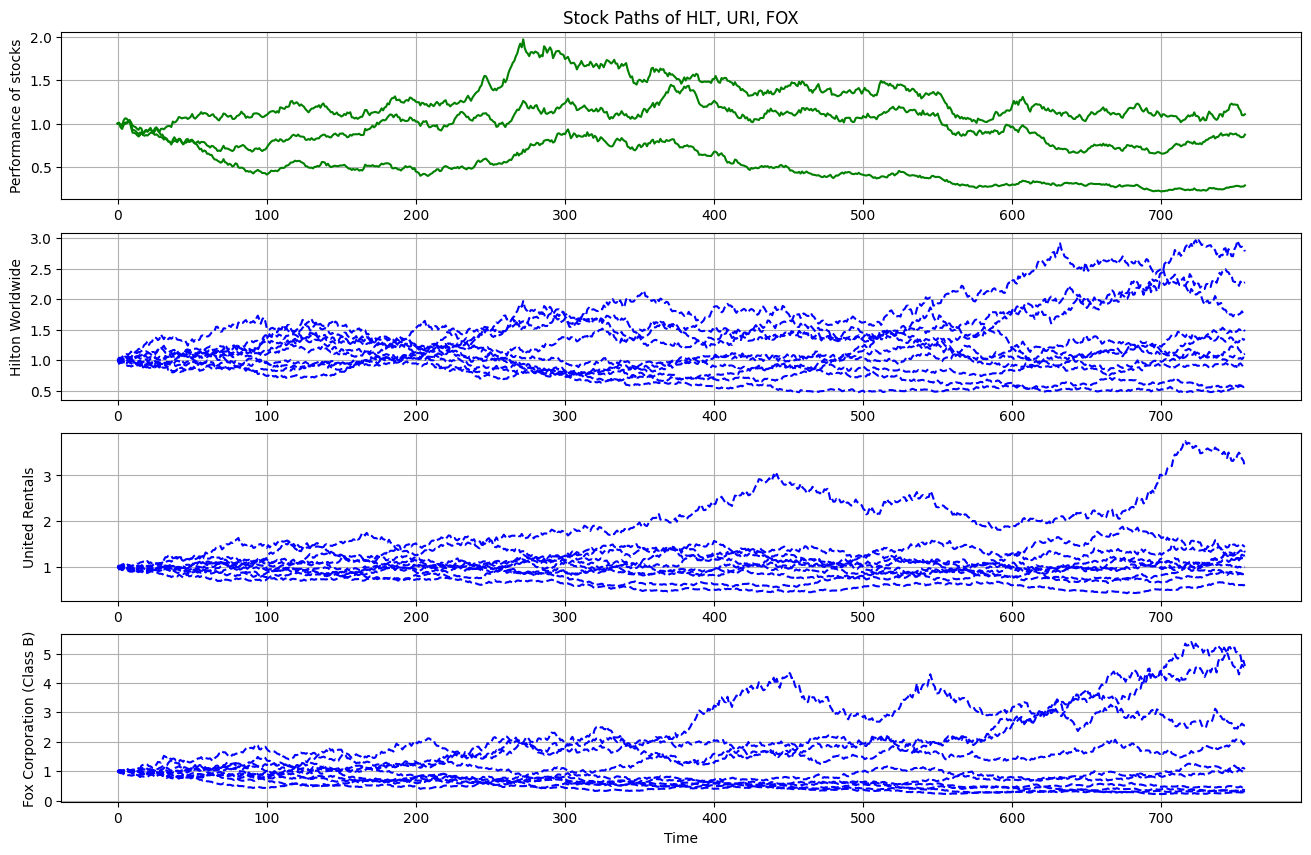

In [47]:
plot_paths(paths, md)

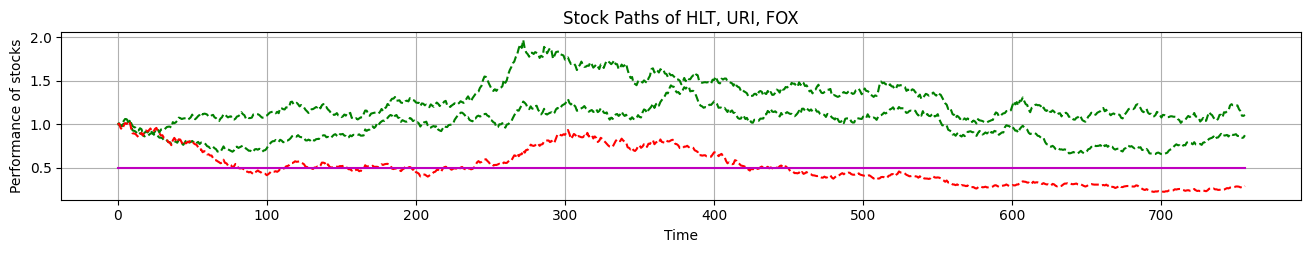

In [48]:
plot_barrier_hit(paths, md, barrier_level=worst_of_barrier_put.barrier_level)

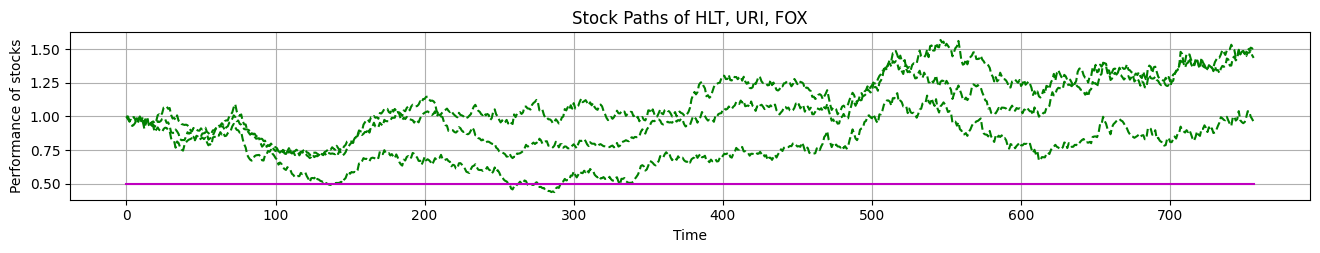

In [49]:
plot_barrier_not_hit(paths, md, barrier_level=worst_of_barrier_put.barrier_level)

## 8. Greeks.

Finally, let's calculate the greeks for the structure. The greeks are computed for the worst-of call itself for simplicity, however, we should keep in mind that the structure supposed **holding worst-of call short**, thus, while hedging we should hedge out the minus values of the presented greeks.

In [50]:
N_POINTS_GRAPH = 10
MIN_SPOT = -0.7
MAX_SPOT = 0.7

In [51]:
def plot_greek(
    greek_fn: Callable[[list[float]], float],
    market_data: MarketData,
    greek_name: str,
    color: str = "g",
) -> None:
    n_stocks = len(market_data)

    data = []
    for stock_i in range(n_stocks):
        spot_start = [1.0] * n_stocks
        if greek_name.lower() == "gamma":
            greeks = [[1.0, greek_fn()[stock_i][stock_i]]]
            for spot in tqdm(np.linspace(MIN_SPOT, MAX_SPOT, N_POINTS_GRAPH)):
                spot_start = [1 + spot] * n_stocks
                greek = greek_fn(spot_start=spot_start)
                greeks.append([1 + spot, greek[stock_i][stock_i]])
        else:
            greeks = [[1.0, greek_fn()[stock_i]]]
            for spot in tqdm(np.linspace(MIN_SPOT, MAX_SPOT, N_POINTS_GRAPH)):
                spot_start[stock_i] = 1 + spot
                greeks.append([1 + spot, greek_fn(spot_start=spot_start)[stock_i]])
        data.append(greeks)

    data = np.array(data)
    data = np.sort(data, axis=1)

    plt.figure(figsize=(14, 7))
    n_stocks = len(market_data.tickers)

    for i in range(n_stocks):
        plt.subplot(n_stocks, 1, i + 1)
        plt.plot(data[i, :, 0], data[i, :, 1], label=f"{greek_name}", color=color)
        plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        plt.grid()

        if i == 0:
            plt.title(f"{greek_name}")

        if i == n_stocks - 1:
            plt.xlabel("Moneyness, %")

        plt.ylabel(f"{market_data.tickers[i].name}")

    plt.show()

100%|██████████| 10/10 [10:01<00:00, 60.19s/it]


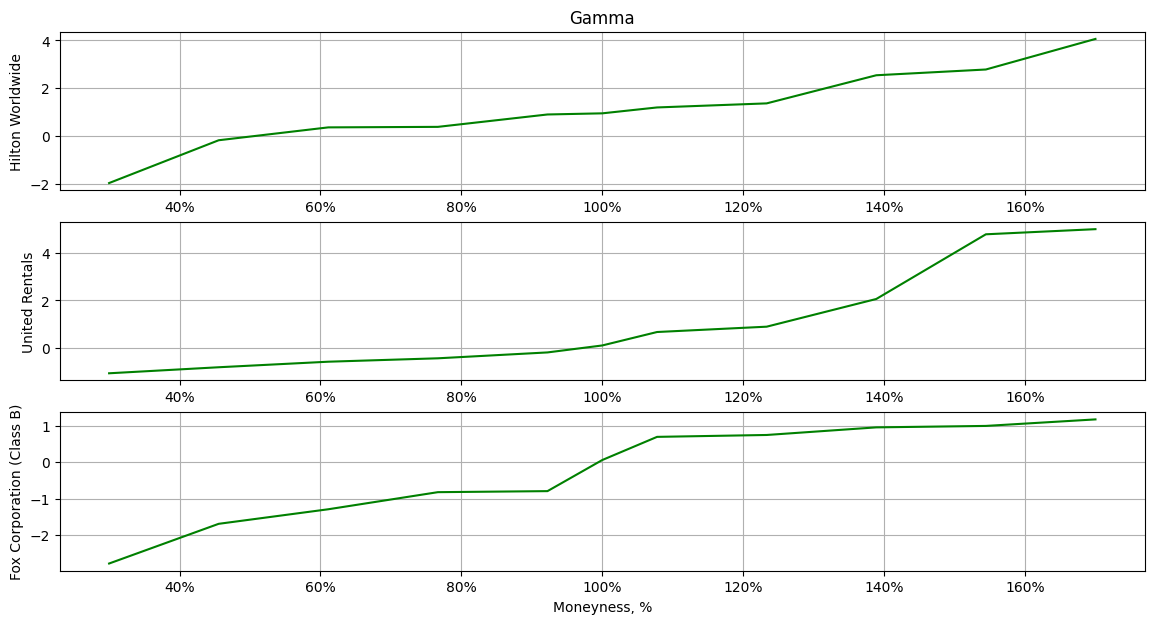

In [52]:
plot_greek(worst_of_barrier_put.gamma, md, greek_name="Gamma")

### Delta.

In [53]:
deltas = worst_of_barrier_put.delta()
for i, delta in enumerate(deltas):
    print(f"* {md.tickers[i].name} => {round(delta, 5)} delta")

* Hilton Worldwide => -0.06773 delta
* United Rentals => -0.07644 delta
* Fox Corporation (Class B) => -0.1288 delta


100%|██████████| 10/10 [01:54<00:00, 11.42s/it]


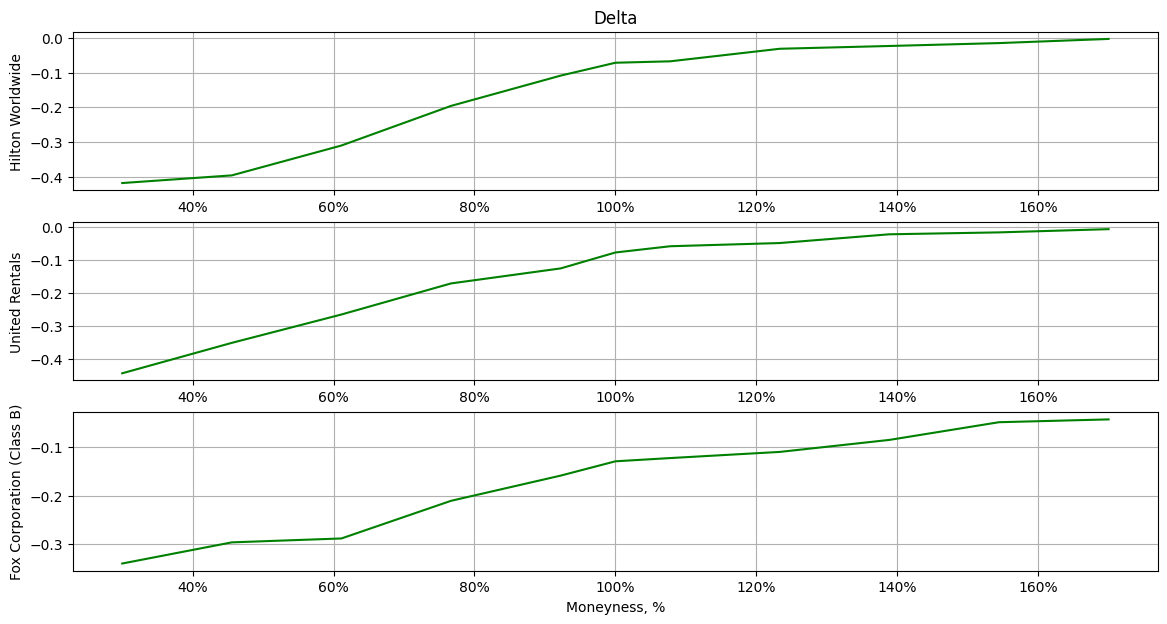

In [54]:
plot_greek(worst_of_barrier_put.delta, md, greek_name="Delta")

Deltas for our worst-of put are negative, as expected - as the option gains, when the stocks fall and breach the barrier, we need to hold stocks short for the hedging purposes.

### Gamma (including X-Gamma).

In [55]:
gammas = worst_of_barrier_put.gamma()
for i, gamma in enumerate(gammas):
    print(f"* {md.tickers[i].name} => {round(gamma[i], 5)} gamma")

* Hilton Worldwide => 0.94561 gamma
* United Rentals => -1.0471 gamma
* Fox Corporation (Class B) => -0.8244 gamma


Here we can notice gammas to be of both signs. The reason for that is the fact that the change in delta, caused by the spot change, might be negavtive for the volatile stock, whenever it is strongly correlated with other stocks - if other stocks are unchanged, but one stock rises, due to correlation it statistically means potential drop with higher volatility, as other stocks (being correlated) show that this stock statistically might fall back, but with higher volatility. It might not be the expected result in terms of financial logic, but in this case **it is driven by the assumption of stocks following multivariate GBM**.

In [56]:
np.sqrt(np.diag(worst_of_barrier_put.underlyings.get_var_covar()))

array([0.3280871 , 0.33625668, 0.45611536])

In [57]:
worst_of_barrier_put.underlyings.get_corr()

array([[1.        , 0.47628634, 0.50055117],
       [0.47628634, 1.        , 0.58898696],
       [0.50055117, 0.58898696, 1.        ]])

Indeed, the negative gamma is the stock with the largest volatility, and all the stocks are highly correlated.

Now, let's have a look at x-gammas.

In [58]:
gammas

array([[ 0.94560925, -0.01009825, -0.00797945],
       [-0.01009825, -1.04710331, -0.01185156],
       [-0.00797945, -0.01185156, -0.82440323]])

Indeed, as the change in one stock's price up should mean that the probability of other stock to drop is now higher, as now the probability that the stocks will diverge (other stocks remain unchanged, but one stock moves => correlation breaks) is higher too => we should increase delta-hedge => we should hold larger short position in stocks.

100%|██████████| 10/10 [5:13:29<00:00, 1880.98s/it]


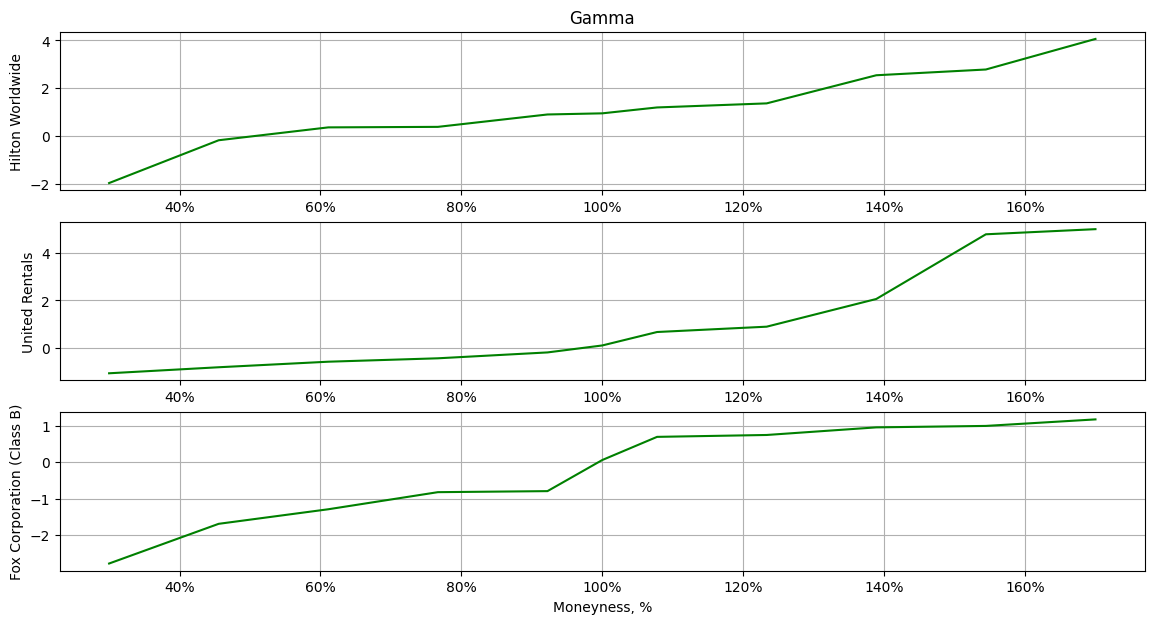

In [59]:
plot_greek(worst_of_barrier_put.gamma, md, greek_name="Gamma")

### Vega.

Further, let's check vegas.

In [60]:
vegas = worst_of_barrier_put.vega()
for i, vega in enumerate(vegas):
    print(f"* {md.tickers[i].name} => {round(vega, 5)} vega")

* Hilton Worldwide => 0.21987 vega
* United Rentals => 0.23853 vega
* Fox Corporation (Class B) => 0.35491 vega


The result is also expected and follows standard logic for vanilla options - the higher the volatility, the higher the probability of negative paths to breach the barrier, while all the positive paths are still producing zero payoff, thus, only negative paths affect the shift in payoff to be more positive, therefore, price should increase.

In [ ]:
plot_greek(worst_of_barrier_put.vega, md, greek_name="Vega")

 40%|████      | 4/10 [1:11:02<1:35:01, 950.19s/it]

### Correlation Sensitivity.

Finally, let's have a look at correlation sensitivity.

In [ ]:
worst_of_barrier_put.correlation_sensitivity()

Correlation sensitivity is negative, as by holding worst-of option long we are short volatility, thus, when volatility rises, the probability of at least one stock to breach the barrier decreases (because all stocks will move "more simultaneously" due to higher correlation, therefore, the price decreases.

**Important note**: the investment idea presented is offered to the client as the opportunity to gain from the rise in correlation at the market. However, we as market-maker that buys worst-of option from the client should not account for the potential rise in correlation and follow the hedging procedures from the risk-neutral perspective. Otherwise, the actual position in correlation would be not only at client's side, but also at our side too, which is divergent from the idea of market-making, but rather taking a position in market variables.